# Use Principle component analysis for reduce the dimentinality 

Optimal number of PCA components: 34
Cross-validation accuracy with optimal components: 0.5752
Number of components for 95% explained variance: 28
Number of components for 99% explained variance: 31

Component-by-component analysis:
   Component  Individual_Variance  Cumulative_Variance
0          1             0.075381             0.075381
1          2             0.074188             0.149568
2          3             0.073225             0.222793
3          4             0.072541             0.295334
4          5             0.071761             0.367095
5          6             0.071339             0.438434
6          7             0.069453             0.507887
7          8             0.069269             0.577156
8          9             0.067824             0.644980
9         10             0.023798             0.668778


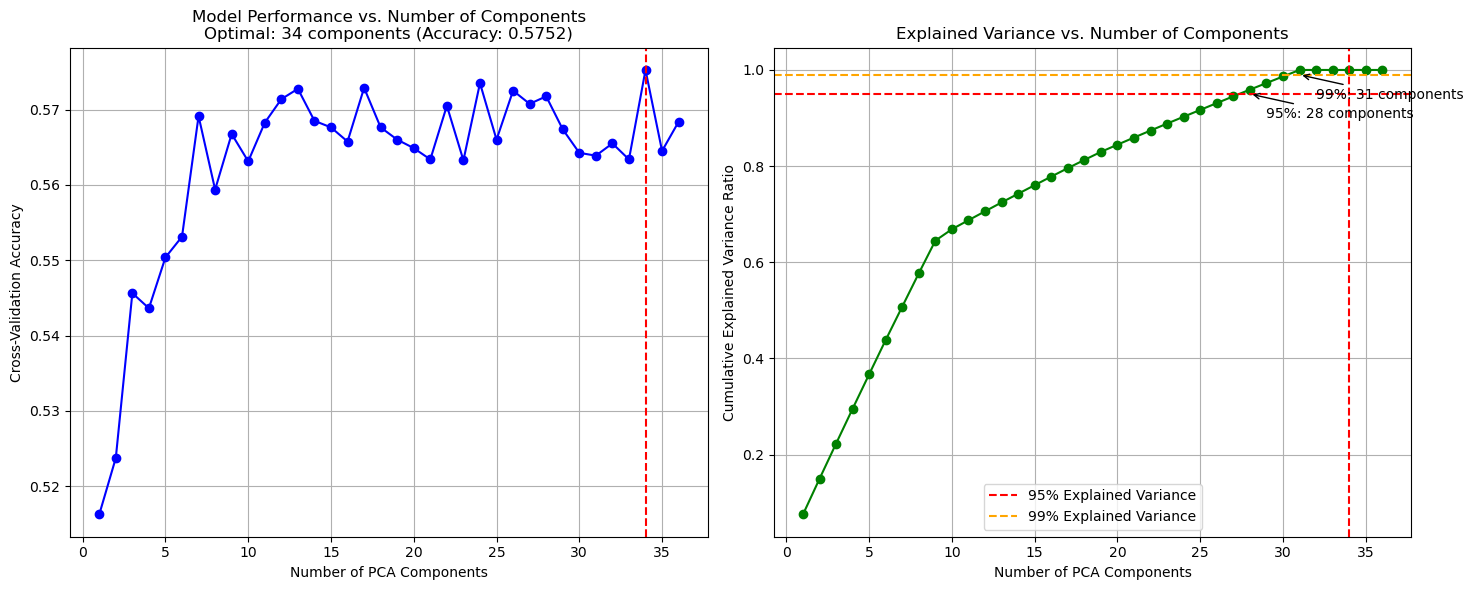


Test accuracy with optimal 34 components: 0.5625
Test accuracy without PCA (all 37 features): 0.5680
Improvement: -0.55%


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def find_optimal_pca_components(X, y, max_components=None, cv=5, random_state=42):
    """
    Find the optimal number of PCA components by evaluating model performance
    and explained variance. Does not include scaling as data is assumed to be
    already scaled.
    
    Parameters:
    -----------
    X : array-like
        Features data (already scaled)
    y : array-like
        Target variable
    max_components : int, optional
        Maximum number of components to consider (default: None, uses all features)
    cv : int, optional
        Number of cross-validation folds (default: 5)
    random_state : int, optional
        Random seed for reproducibility (default: 42)
        
    Returns:
    --------
    dict
        Dictionary containing results and visualizations
    """
    # Set max_components if not provided
    if max_components is None:
        max_components = X.shape[1]
    else:
        max_components = min(max_components, X.shape[1])
    
    # Create lists to store results
    n_components_range = range(1, max_components + 1)
    cv_scores = []
    explained_var_ratio = []
    cumulative_var_ratio = []
    
    # Perform PCA and evaluate model performance for different n_components
    pca = PCA(random_state=random_state)
    pca.fit(X)
    
    # Get explained variance ratios
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var_ratio = np.cumsum(explained_var_ratio)
    
    # Evaluate model performance for different n_components
    for n_comp in n_components_range:
        # Create pipeline with PCA and RandomForest (no scaling)
        pipeline = Pipeline([
            ('pca', PCA(n_components=n_comp, random_state=random_state)),
            ('clf', RandomForestClassifier(random_state=random_state))
        ])
        
        # Perform cross-validation
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
        cv_scores.append(np.mean(scores))
    
    # Find optimal n_components based on cross-validation scores
    optimal_n_components = n_components_range[np.argmax(cv_scores)]
    max_cv_score = max(cv_scores)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Model performance
    ax1.plot(n_components_range, cv_scores, 'o-', color='blue')
    ax1.axvline(x=optimal_n_components, color='red', linestyle='--')
    ax1.set_xlabel('Number of PCA Components')
    ax1.set_ylabel('Cross-Validation Accuracy')
    ax1.set_title(f'Model Performance vs. Number of Components\nOptimal: {optimal_n_components} components (Accuracy: {max_cv_score:.4f})')
    ax1.grid(True)
    
    # Plot 2: Explained variance
    ax2.plot(n_components_range, cumulative_var_ratio[:max_components], 'o-', color='green')
    ax2.axhline(y=0.95, color='red', linestyle='--', label='95% Explained Variance')
    ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% Explained Variance')
    ax2.axvline(x=optimal_n_components, color='red', linestyle='--')
    
    # Find number of components for 95% and 99% explained variance
    n_components_95 = np.argmax(cumulative_var_ratio >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_var_ratio >= 0.99) + 1
    
    ax2.annotate(f'95%: {n_components_95} components', 
                xy=(n_components_95, 0.95), 
                xytext=(n_components_95+1, 0.95-0.05),
                arrowprops=dict(arrowstyle='->'))
    
    ax2.annotate(f'99%: {n_components_99} components', 
                xy=(n_components_99, 0.99), 
                xytext=(n_components_99+1, 0.99-0.05),
                arrowprops=dict(arrowstyle='->'))
    
    ax2.set_xlabel('Number of PCA Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Explained Variance vs. Number of Components')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    # Create a more detailed analysis with component-by-component explanation
    individual_var = pd.DataFrame({
        'Component': range(1, len(explained_var_ratio) + 1),
        'Individual_Variance': explained_var_ratio,
        'Cumulative_Variance': cumulative_var_ratio
    })
    
    # Return results
    results = {
        'optimal_n_components': optimal_n_components,
        'max_cv_score': max_cv_score,
        'n_components_95_var': n_components_95,
        'n_components_99_var': n_components_99,
        'cv_scores': cv_scores,
        'explained_variance_ratio': explained_var_ratio,
        'cumulative_variance_ratio': cumulative_var_ratio,
        'component_analysis': individual_var,
        'figure': fig
    }
    
    return results

# Example usage
def main():
    """
    Example usage of the find_optimal_pca_components function.
    Replace with your actual data loading and processing code.
    """
    # For demonstration, we'll generate synthetic data
    # Replace this with your actual data loading code
    df = pd.read_csv(f'feature_engineered_dataset.csv')

    X = df.drop(columns = ['remainder__Decided to Pursue MBA?'], axis = 1)
    y = df['remainder__Decided to Pursue MBA?']
    
    # Split data for independent testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Note: In a real scenario, you would normally scale here, but since 
    # your data is already scaled, we skip this step
    
    # Find optimal number of PCA components
    results = find_optimal_pca_components(X_train, y_train, max_components=37)
    
    # Print optimal number of components
    print(f"Optimal number of PCA components: {results['optimal_n_components']}")
    print(f"Cross-validation accuracy with optimal components: {results['max_cv_score']:.4f}")
    print(f"Number of components for 95% explained variance: {results['n_components_95_var']}")
    print(f"Number of components for 99% explained variance: {results['n_components_99_var']}")
    
    # Show component-by-component analysis
    print("\nComponent-by-component analysis:")
    print(results['component_analysis'].head(10))
    
    # Show the plot
    plt.show()
    
    # Now train a model with the optimal number of components and evaluate on test set
    optimal_pipeline = Pipeline([
        ('pca', PCA(n_components=results['optimal_n_components'], random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    
    # Train and evaluate
    optimal_pipeline.fit(X_train, y_train)
    test_accuracy = optimal_pipeline.score(X_test, y_test)
    
    print(f"\nTest accuracy with optimal {results['optimal_n_components']} components: {test_accuracy:.4f}")
    
    # Compare with original model without PCA
    original_pipeline = Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ])
    
    original_pipeline.fit(X_train, y_train)
    original_test_accuracy = original_pipeline.score(X_test, y_test)
    
    print(f"Test accuracy without PCA (all 37 features): {original_test_accuracy:.4f}")
    print(f"Improvement: {(test_accuracy - original_test_accuracy) * 100:.2f}%")

if __name__ == "__main__":
    main()

# Hyper Paramete tuning 

[I 2025-03-20 22:04:30,612] A new study created in memory with name: no-name-3a485148-b594-4d1a-8f5c-b77f14275941


Class distribution: [4093 5907]
Class ratios: [0.4093 0.5907]


[I 2025-03-20 22:04:55,808] Trial 0 finished with value: 0.5155230168280102 and parameters: {'n_layers': 1, 'units_1': 179, 'units_2': 52, 'units_3': 245, 'units_4': 27, 'dropout_1': 0.2954641604087571, 'dropout_2': 0.2930548047207839, 'dropout_3': 0.2962584563581587, 'dropout_4': 0.1917274962327714, 'activation': 'relu', 'l1': 4.807555923688986e-07, 'l2': 0.0001731447857688503, 'optimizer': 'adam', 'learning_rate': 0.0032288441971195124, 'momentum': 0.41133103205909743, 'batch_size': 16}. Best is trial 0 with value: 0.5155230168280102.
[I 2025-03-20 22:05:19,912] Trial 1 finished with value: 0.502147937219006 and parameters: {'n_layers': 2, 'units_1': 173, 'units_2': 245, 'units_3': 98, 'units_4': 254, 'dropout_1': 0.35755171574127737, 'dropout_2': 0.48531835909202775, 'dropout_3': 0.43328973409344657, 'dropout_4': 0.49080841133483166, 'activation': 'elu', 'l1': 0.0002387447981453007, 'l2': 1.6957063931732206e-08, 'optimizer': 'adam', 'learning_rate': 0.0026777165107034744, 'momentum'


Best Hyperparameters:
n_layers: 2
units_1: 130
units_2: 225
units_3: 131
units_4: 145
dropout_1: 0.4937534117605381
dropout_2: 0.2642473811836487
dropout_3: 0.3993102139047163
dropout_4: 0.3908873691656928
activation: relu
l1: 2.4200204603657365e-07
l2: 0.00044960134343524774
optimizer: adam
learning_rate: 0.0007863640307519507
momentum: 0.5908429060753364
batch_size: 64
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5056 - auc: 0.4987 - loss: 0.8814 - val_accuracy: 0.5319 - val_auc: 0.4965 - val_loss: 0.8455 - learning_rate: 7.8636e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5042 - auc: 0.5066 - loss: 0.8477 - val_accuracy: 0.5050 - val_auc: 0.4706 - val_loss: 0.8304 - learning_rate: 7.8636e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5078 - auc: 0.5095 - loss: 0.8282 - val_accuracy: 0.5375 - val_auc: 0.4752 - val_loss: 0.8119 - learning_rate: 7.8636e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc

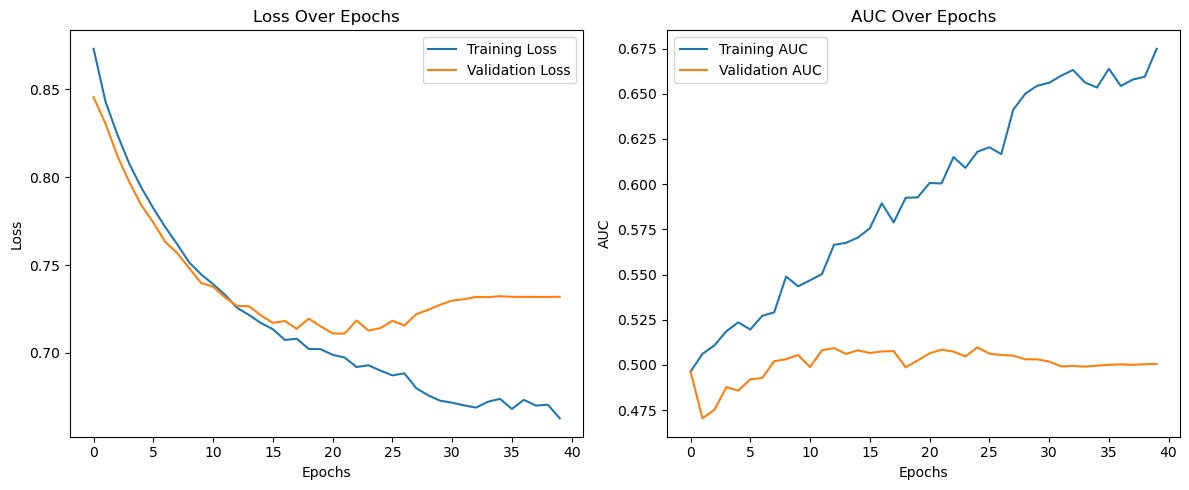

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
63/63 ━━━━━━━━━━

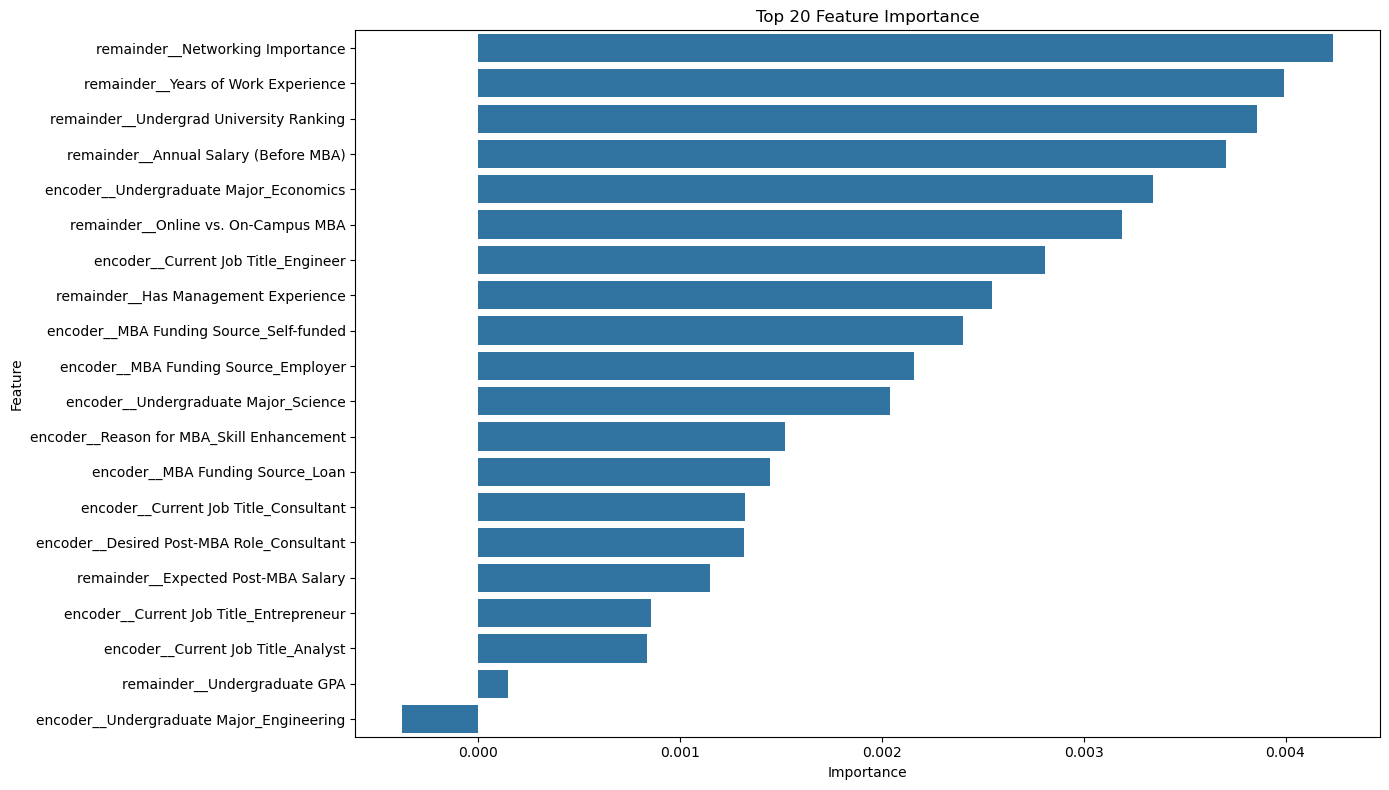


Top 10 Most Important Features:
                                    Feature  Importance       Std
30         remainder__Networking Importance    0.004237  0.005826
25      remainder__Years of Work Experience    0.003994  0.005762
28  remainder__Undergrad University Ranking    0.003860  0.005172
26    remainder__Annual Salary (Before MBA)    0.003706  0.004622
2    encoder__Undergraduate Major_Economics    0.003342  0.002897
35      remainder__Online vs. On-Campus MBA    0.003191  0.003629
7       encoder__Current Job Title_Engineer    0.002810  0.001658
33     remainder__Has Management Experience    0.002545  0.002240
13  encoder__MBA Funding Source_Self-funded    0.002401  0.001437
10     encoder__MBA Funding Source_Employer    0.002158  0.001627

Model saved as 'best_mba_decision_model.h5'


In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to load and prepare your data
def load_data():
    # Load the data_v1 dataset
    data = pd.read_csv('feature_engineered_dataset.csv')
    
    # Assuming that 'remainder__Decided to Pursue MBA?' is your target column
    # Adapt this to match your actual target column name
    y = data['remainder__Decided to Pursue MBA?']
    
    # Drop the target column to get features
    X = data.drop('remainder__Decided to Pursue MBA?', axis=1)
    
    # No scaling needed since the dataset is already scaled
    return X, y

# Function to create a model with given hyperparameters
def create_model(params):
    # Use Functional API with Input layer instead of Sequential with input_dim
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    
    # First layer
    x = Dense(
        units=params['units_1'],
        activation=params['activation'],
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=params['l1'], l2=params['l2'])
    )(inputs)
    x = Dropout(params['dropout_1'])(x)
    
    # Hidden layers
    for i in range(params['n_layers']):
        x = Dense(
            units=params[f'units_{i+2}'],
            activation=params['activation'],
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=params['l1'], l2=params['l2'])
        )(x)
        x = Dropout(params[f'dropout_{i+2}'])(x)
    
    # Output layer (binary classification)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    optimizer_name = params['optimizer']
    learning_rate = params['learning_rate']
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=params['momentum'])
    else:  # rmsprop
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    params = {
        # Network architecture
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'units_1': trial.suggest_int('units_1', 16, 256),
        'units_2': trial.suggest_int('units_2', 16, 256),
        'units_3': trial.suggest_int('units_3', 16, 256),
        'units_4': trial.suggest_int('units_4', 16, 256),
        'dropout_1': trial.suggest_float('dropout_1', 0.0, 0.5),
        'dropout_2': trial.suggest_float('dropout_2', 0.0, 0.5),
        'dropout_3': trial.suggest_float('dropout_3', 0.0, 0.5),
        'dropout_4': trial.suggest_float('dropout_4', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'elu', 'selu']),

        # Regularization
        'l1': trial.suggest_float('l1', 1e-8, 1e-3, log=True),
        'l2': trial.suggest_float('l2', 1e-8, 1e-3, log=True),

        # Optimization
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'momentum': trial.suggest_float('momentum', 0.0, 0.99),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'epochs': 100,  # Fixed number of maximum epochs with early stopping
    }

    # Use stratified k-fold cross-validation
    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    cv_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Split data - no scaling needed
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Calculate class weights if imbalanced
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_fold_train),
            y=y_fold_train
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

        # Create and train model
        model = create_model(params)

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_auc',
            patience=10,
            restore_best_weights=True,
            mode='max'
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )

        # Train the model
        history = model.fit(
            X_fold_train, y_fold_train,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_data=(X_fold_val, y_fold_val),
            class_weight=class_weight_dict,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        # Evaluate on validation set
        y_pred_proba = model.predict(X_fold_val, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Get AUC score
        auc = roc_auc_score(y_fold_val, y_pred_proba)
        cv_scores.append(auc)

        # Free up memory
        tf.keras.backend.clear_session()

    # Return the mean AUC score across all folds
    return np.mean(cv_scores)

# Function to evaluate the best model
def evaluate_best_model(best_params, X_train, y_train, X_test, y_test):
    # Create model with best parameters
    model = create_model(best_params)

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max'
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate on test set
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print("\nFinal Model Evaluation on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC ROC: {auc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

# Feature importance analysis
def analyze_feature_importance(model, feature_names, X_test, y_test):
    # For neural networks, we'll create a custom permutation importance implementation
    # since sklearn's permutation_importance expects an estimator with fit method
    
    # Get baseline score
    baseline_preds = model.predict(X_test)
    baseline_score = roc_auc_score(y_test, baseline_preds)
    
    # Store importance scores
    importances = []
    std_importances = []
    
    # Number of permutation runs
    n_repeats = 10
    
    # For each feature
    for i in range(X_test.shape[1]):
        feature_importances = []
        
        # Repeat permutation multiple times
        for _ in range(n_repeats):
            # Create a copy of the test data
            X_permuted = X_test.copy()
            
            # Permute the feature
            X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i].values)
            
            # Predict with permuted feature
            preds_permuted = model.predict(X_permuted)
            
            # Calculate new score
            permuted_score = roc_auc_score(y_test, preds_permuted)
            
            # Feature importance is the decrease in performance
            feature_importances.append(baseline_score - permuted_score)
        
        # Calculate mean and std of importance
        importances.append(np.mean(feature_importances))
        std_importances.append(np.std(feature_importances))
    
    # Create a DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Std': std_importances
    })
    
    # Sort by importance (higher values = more important)
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Main execution
if __name__ == "__main__":
    # Load data
    X, y = load_data()

    if X is None or y is None:
        print("Error loading data. Please check the data_v1.csv file and column names.")
        exit()

    # Split data into training and testing sets - no scaling needed
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Check for class imbalance
    class_distribution = np.bincount(y)
    print(f"Class distribution: {class_distribution}")
    print(f"Class ratios: {class_distribution / len(y)}")

    # Create an Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

    # Get the best hyperparameters
    best_params = study.best_params
    print("\nBest Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # Add the fixed epochs parameter
    best_params['epochs'] = 100

    # Evaluate the best model
    best_model, history = evaluate_best_model(
        best_params, X_train, y_train, X_test, y_test
    )

    # Analyze feature importance
    feature_names = X.columns.tolist()
    importance_df = analyze_feature_importance(best_model, feature_names, X_test, y_test)

    # Print top 10 most important features
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

    # Save the best model
    best_model.save('best_mba_decision_model.h5')
    print("\nModel saved as 'best_mba_decision_model.h5'")